o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

Episode 1999/2000.

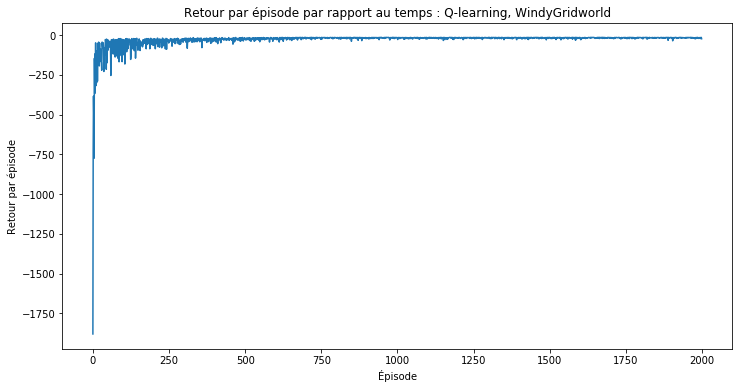

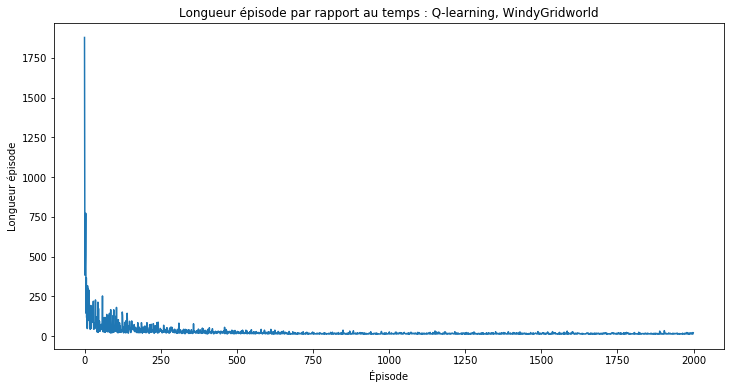

In [20]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Optimisation de politique avec méthode Q-learning
Politique epsilon-vorace
Environnement WindyGridWorldEnv du livre de Barto&Sutton 2018 Ex.6.5
Le code de l'environnement est tiré de 
https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/windy_gridworld.py 
"""
import gym
import numpy as np
import random
import itertools
import sys
import matplotlib
from matplotlib import pyplot as plt

from gym import spaces
from gym.utils import seeding
from collections import defaultdict
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

def afficher_longueur_episode(longueur_episode):
    """
    Afficher l'évolution des longueurs d'épisodes avec le temps
    """
    figure1 = plt.figure(figsize=(12,6))
    plt.plot(longueur_episode)
    plt.xlabel("Épisode")
    plt.ylabel("Longueur épisode")
    plt.title("Longueur épisode par rapport au temps : Q-learning, WindyGridworld")
    
def afficher_retour_par_episode(retour_par_episode):
    """
    Afficher l'évolution des récompenses par épisode
    """
    figure1 = plt.figure(figsize=(12,6))
    plt.plot(retour_par_episode)
    plt.xlabel("Épisode")
    plt.ylabel("Retour par épisode")
    plt.title("Retour par épisode par rapport au temps : Q-learning, WindyGridworld")

def politique_optimale_Q(env, nombre_episodes, max_t=99, gamma=1.0, alpha=0.1, epsilon=0.1):
    """
    Optimisation de politique avec méthode Q-learning
        env: environnement de type OpenAI gym
        nombre_episodes: nombre d'épisodes générés pour l'apprentissage
        gamma: facteur d'escompte des récompenses futures
        alpha: taux d'apprentissage
        epsilon: probabilité pour politique e-vorace
    Retour:
        Q: np.array(nb_etats,nb_actions)
        retour_par_episode: tableau des retours par épisode
        longueur_episode: tableau des longueurs d'épisode
    """
    longueur_episode = np.zeros(nombre_episodes)
    retour_par_episode = np.zeros(nombre_episodes)
    nb_actions = env.action_space.n
    nb_etats = env.observation_space.n
    Q = np.zeros((nb_etats, nb_actions))
    
    for i_episode in range(nombre_episodes):
        if (i_episode+1) % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, nombre_episodes), end="")
            sys.stdout.flush()

        etat = env.reset()
        for t in itertools.count():
            
            # Choisir action selon politique e-vorace
            unif_01 = np.random.uniform(0, 1)
            if unif_01 > epsilon:
                action = np.argmax(Q[etat,:])
            else:
                action = env.action_space.sample()
            
            etat_suivant, recompense, final, _ = env.step(action)
            Q[etat,action] = Q[etat,action]+alpha*(recompense+gamma*np.max(Q[etat_suivant,:])-Q[etat,action])
            retour_par_episode[i_episode]+=recompense
            if final:
                longueur_episode[i_episode] = t
                break
            etat = etat_suivant
        
    return Q,retour_par_episode,longueur_episode

env = WindyGridworldEnv()
env.render()

Q,retour_par_episode,longueur_episode = politique_optimale_Q(env, nombre_episodes=2000,alpha=0.1)
afficher_retour_par_episode(retour_par_episode)
afficher_longueur_episode(longueur_episode)

In [16]:
""" Test du jeu après optimisation de Q """
nb_episodes = 3
max_etapes = 99 
env.reset()
retour_par_episode = []

for episode in range(nb_episodes):
    etat = env.reset()
    final = False
    total_recompenses = 0
    print("**********************************")
    print("Épisode : ", episode)

    for t in range(max_etapes):
        env.render()
        action = np.argmax(Q[etat])
        
        etat_suivant, recompense, final, _ = env.step(action)
        
        total_recompenses += recompense
        
        if final:
            retour_par_episode.append(total_recompenses)
            print ("Total des récompenses de l'épisode :", total_recompenses)
            print("Longueur épisode :", t)
            env.render()
            break
        etat = etat_suivant
env.close()
print ("Moyenne de récompenses par épisode: " +  str(sum(retour_par_episode)/nb_episodes))

**********************************
Épisode :  0
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o 